In [17]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

I0000 00:00:1734058555.477003 8426754 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [18]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [19]:
%env ROCKFISH_API_KEY=YOUR_API_KEY
conn = rf.Connection.from_env()

In [20]:
# download our example of tabular data: fall_detection.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/fall_detection.csv

File ‘fall_detection.csv’ already there; not retrieving.



I0000 00:00:1734058558.192707 8426754 fork_posix.cc:77] Other threads are currently calling into gRPC, skipping fork() handlers


In [21]:
dataset = rf.Dataset.from_csv("fall_detection", "fall_detection.csv")
dataset.to_pandas()

,Age range of patient,Sex,Involvement of medication associated with fall risk,Whether a fall prevention protocol was implemented,Reason for incident,Whether a restraint prescription was given,Whether a physical therapy prescription was given,BBS Score,Body Temperature,Heart Rate,...,Chronic Heart Failure,Stroke,Frozen shoulder,Osteoarthritis of hip,Cerebellar Ataxia,Hemiparesis,GB Syndrome,Fall risk level,Ischemic Heart Disease,Cervical sopondylitis
0,60<70,M,Yes,Yes,Slip,No,Yes,41,97,80,...,No,No,No,No,No,No,No,High,No,No
1,30<40,F,Yes,Yes,Loss of balance,No,No,41,96,78,...,No,No,No,No,No,No,No,High,No,No
2,60<70,M,Yes,Yes,Mental confusion,No,Yes,43,98,81,...,No,No,No,No,No,No,No,High,No,No
3,80<90,M,Yes,Yes,Mental confusion,No,Yes,40,99,82,...,No,No,No,No,No,No,No,High,No,No
4,60<70,M,Yes,Yes,Loss of balance,No,Yes,40,96,90,...,No,No,No,No,No,No,No,High,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,50<60,M,No,No,Muscle weakness,No,No,44,97,67,...,No,No,No,No,No,No,No,Moderate,No,No
2578,80<90,F,No,No,Hypotension,No,No,43,97,96,...,No,No,No,No,No,No,No,Moderate,No,No
2579,30<40,F,No,No,Muscle weakness,No,No,43,96,76,...,No,No,No,No,No,No,No,Moderate,No,No
2580,60<70,M,No,Yes,Loss of balance,No,No,44,99,101,...,No,No,No,No,No,No,No,Moderate,No,No


In [22]:
# user can manually provide a list of categorical column names
categorical_fields = (
    dataset.to_pandas().select_dtypes(include=["object"]).columns
)
config = {
    "encoder": {
        "metadata": [
            {"field": field, "type": "categorical"}
            for field in categorical_fields
        ]
        + [
            {"field": field, "type": "continuous"}
            for field in dataset.table.column_names
            if field not in categorical_fields
        ],
    },
    "tabular-gan": {
        "epochs": 100,
        "records": 2582,
    },
}
# create train action
train = ra.TrainTabGAN(config)

In [23]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)

print(f"Workflow: {workflow.id()}")

Workflow: fZ2rmFLtX69FVCv7uBvgW


In [24]:
async for progress in workflow.progress().notebook():
    pass

  0%|          | 0/100 [00:00<?, ?it/s]

In [25]:
model = await workflow.models().nth(0)
model

Model(id='dc7e6547-b8fd-11ef-9e7e-665e8c8b87d7', labels={'workflow_id': 'fZ2rmFLtX69FVCv7uBvgW'}, create_time=datetime.datetime(2024, 12, 13, 2, 56, 33, tzinfo=datetime.timezone.utc), size_bytes=5748224)

In [26]:
generate = ra.GenerateTabGAN(config)
save = ra.DatasetSave({"name": "synthetic"})
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 5UdVkCJ9Ti03nofuyEEshx


In [27]:
async for log in workflow.logs():
    print(log)

2024-12-13T02:56:47Z generate-tab-gan: INFO Generating 2582 records
2024-12-13T02:56:47Z dataset-save: INFO Saved dataset '5qRUXeOq3tsiPXfg5kDufD' with 2582 rows


In [28]:
syn = None
async for sds in workflow.datasets():
    syn = await sds.to_local(conn)
syn.to_pandas()

,Age range of patient,Sex,Involvement of medication associated with fall risk,Whether a fall prevention protocol was implemented,Reason for incident,Whether a restraint prescription was given,Whether a physical therapy prescription was given,BBS Score,Body Temperature,Heart Rate,...,Chronic Heart Failure,Stroke,Frozen shoulder,Osteoarthritis of hip,Cerebellar Ataxia,Hemiparesis,GB Syndrome,Fall risk level,Ischemic Heart Disease,Cervical sopondylitis
0,≥ 90,F,No,No,Mental confusion,No,No,44,97,69,...,No,No,No,No,No,No,No,High,No,No
1,< 1,F,Yes,Yes,Hypotension,No,No,38,97,64,...,No,No,No,No,No,No,No,Moderate,No,No
2,< 1,M,Yes,Yes,Loss of balance,No,Yes,39,95,73,...,No,No,No,No,No,No,No,High,No,No
3,40<50,M,No,No,Mental confusion,No,No,44,98,79,...,No,No,No,No,No,No,No,Moderate,No,No
4,60<70,F,No,Yes,Mental confusion,No,Yes,43,96,92,...,No,No,No,No,Yes,No,No,High,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,60<70,F,No,No,Loss of balance,No,No,43,97,69,...,No,No,No,No,No,No,No,Low,No,No
2578,60<70,F,Yes,No,Slip,No,No,43,97,97,...,No,No,No,No,No,No,No,Moderate,No,No
2579,60<70,F,No,No,Loss of balance,No,No,42,95,87,...,No,No,No,No,No,No,No,High,No,No
2580,80<90,F,No,Yes,Muscle weakness,No,Yes,40,97,65,...,No,No,No,No,No,No,No,High,No,No


### Evaluation


**1. categorical columns**


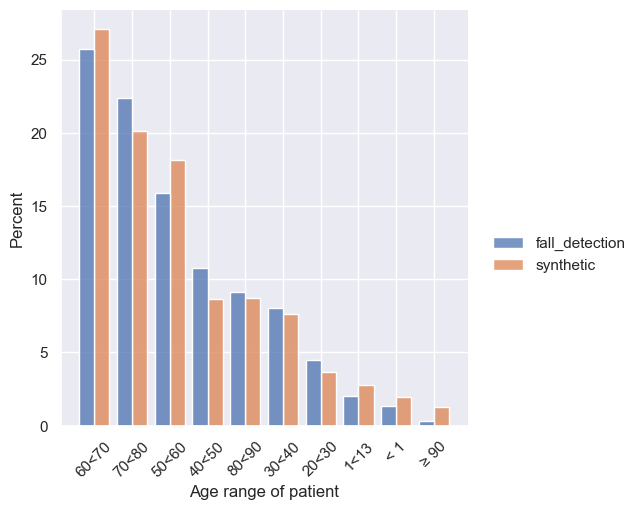

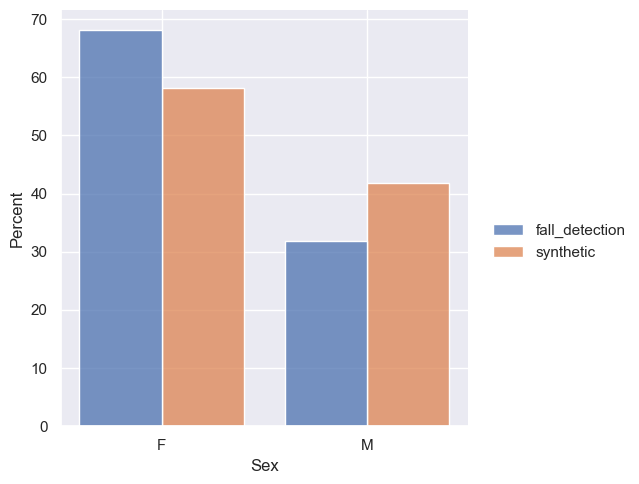

In [29]:
for col in ["Age range of patient", "Sex"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=10)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=10)
    rl.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")

**2. numerical columns**


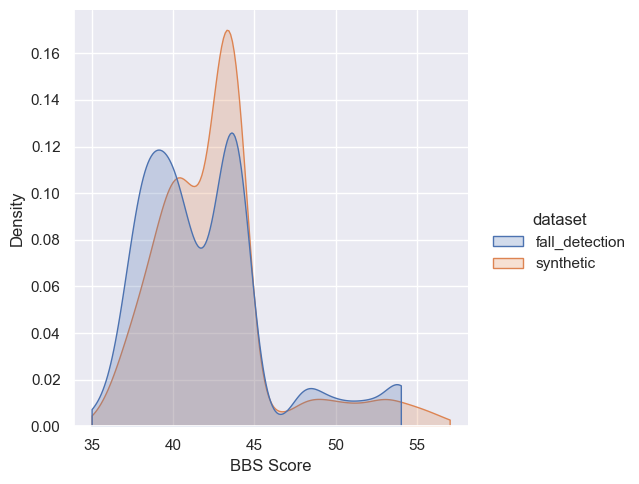

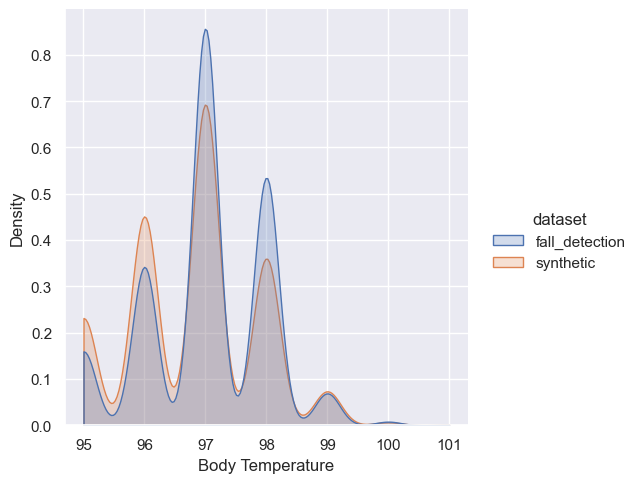

In [30]:
for col in ["BBS Score", "Body Temperature"]:
    rl.vis.plot_kde([dataset, syn], col)

**3. correlation between numerical columns**


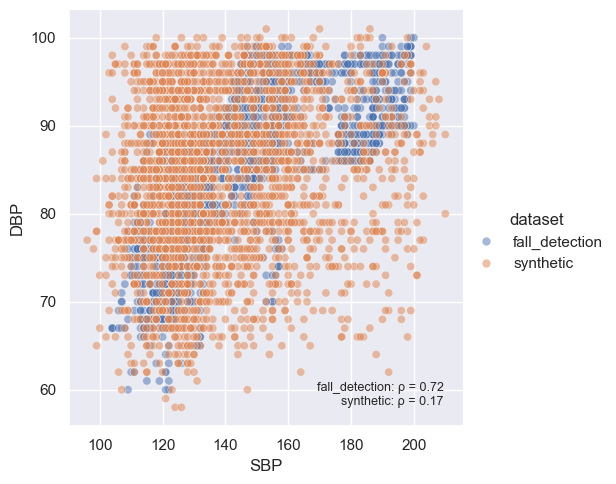

In [31]:
col1 = "SBP"
col2 = "DBP"
rl.vis.plot_correlation([dataset, syn], col1, col2, alpha=0.5)

**4. correlation heatmap between several numerical columns**


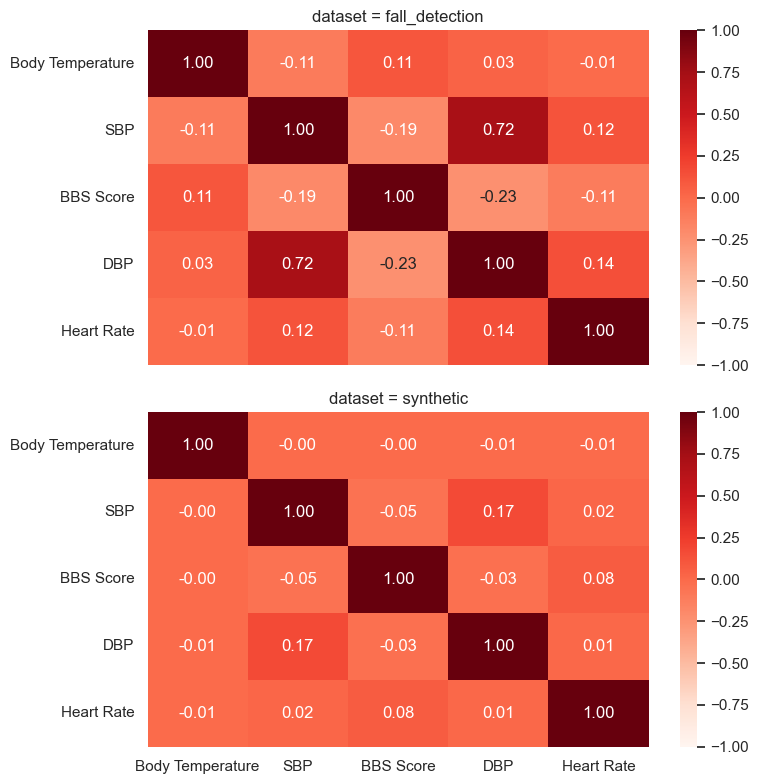

In [33]:
n_cols = ["Body Temperature", "SBP", "BBS Score", "DBP", "Heart Rate"]
rl.vis.plot_correlation_heatmap([dataset, syn], n_cols, annot=True, fmt=".2f")